#### Ancestral recombination of Coronaviridae lineages

* Measure the 

#### Methods

Non-recombining regions (NRRs) were identified using the
[pairwise homoplasy index](https://doi.org/10.1534/genetics.105.048975) ($\phi_w$)
implemented in [PhiPack](http://www.maths.otago.ac.nz/~dbryant/software.html). Phylogenetic inference for each NRR was carried out using 
[RAxML](https://doi.org/10.1093/bioinformatics/btu033),
and correlation tests were carried out with [SuchTree](http://joss.theoj.org/papers/23bac1ae69cfaf201203dd52d7dd5610) and [scipy](https://doi.org/10.1038/s41592-019-0686-2). Plots were
generated using [pandas](https://doi.org/10.5281/zenodo.3509134), [seaborn](https://zenodo.org/record/3767070), and [dna_features_viewer](https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer).

#### Results

The pairwise homoplasy index reveals four distinct blocks within which
there does not appear to be significant evidence of recombination. The four
blocks have similar but distinct phylogenies. Interestingly, blocks that
are adjacent in the SARS-CoV-2 genome do not appear to have the most 
similar histories. Block 1, which spans roughly the first third of
ORF1ab, and block 2, which spans ORF3a and E, have the most similar 
phylogenetic histories ($\tau = 0.4$, $p = 2\times 10^{-300}$). Block 2, which 
spans the first half of the gene encoding the spike protien and block 4, which
includes M, ORF6, ORF7a, ORF7b, ORF8, N and ORF10 have the most dissimilar
phylogenetic histories ($\tau = 0.1$, $p=2\times 10^{-21}$).

In [6]:
import seaborn
import pandas

%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


Run `PhiPack` over the alignment with scanning windows of 500bp, 1000bp and 5000bp.

In [227]:
# 500bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 500 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w500.csv
!mv Profile.log Profile_w500.log
# 1000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 1000 -m 25 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w1000.csv
!mv Profile.log Profile_w1000.log
# 5000bp scanning size
!~/pkg/PhiPack/src/Profile -v -w 100 -n 5000 -m 100 -f data/refcov89_fullgenome_alignment.fasta &> /dev/null
!mv Profile.csv Profile_w5000.csv
!mv Profile.log Profile_w5000.log

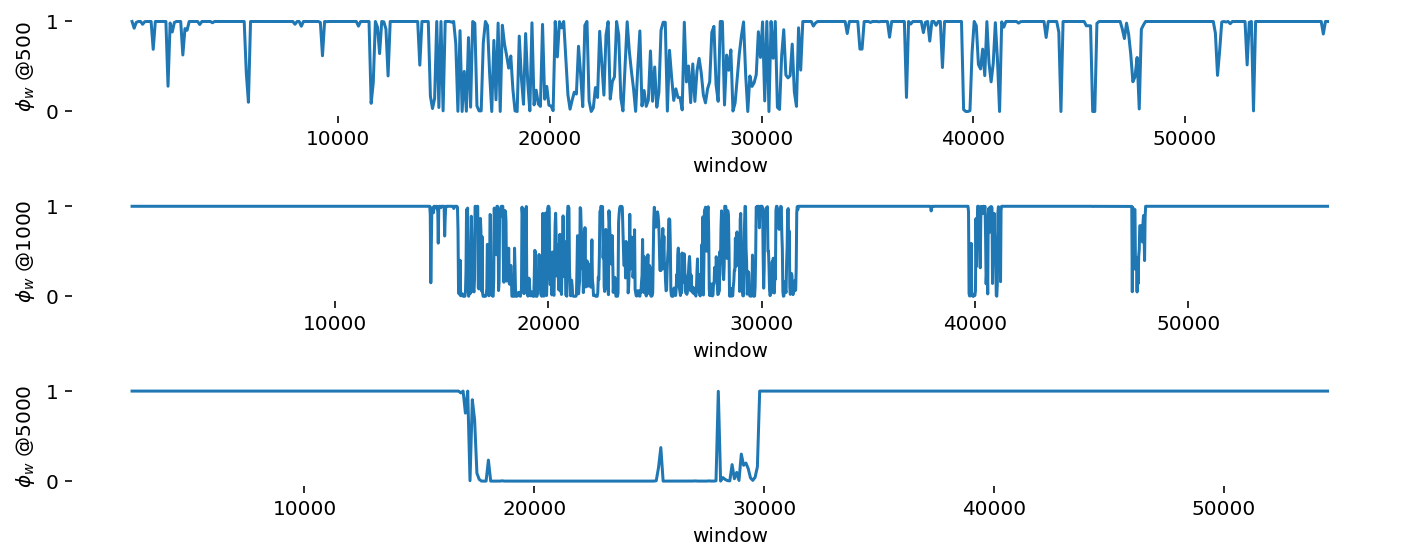

In [15]:
figure( figsize=( 10, 4 ) )

df500 = pandas.read_csv( 'Profile_w500.csv', header=None )
df500.columns = [ 'window', 'PHI' ]

df1000 = pandas.read_csv( 'Profile_w1000.csv', header=None )
df1000.columns = [ 'window', 'PHI' ]

df5000 = pandas.read_csv( 'Profile_w5000.csv', header=None )
df5000.columns = [ 'window', 'PHI' ]

for n,(df,scansize) in enumerate( [ ( df500, '500'), (df1000, '1000'), (df5000, '5000') ] ) :
    subplot( 3, 1, n+1 )
    ax = seaborn.lineplot( df.window,  df.PHI )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([10000,20000,30000,40000,50000])

    ylabel( r'$\phi_w$ @' + scansize )

tight_layout()

In [3]:
from Bio import SeqIO

with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
    for record in SeqIO.parse( f, format='fasta' ) :
        if record.id.split('|')[0] == 'NC_045512' : break
            
len(record)

57049

Map $\phi_w$ values from alignment coordinates to reference genome coordinates.

Text(0, 0.5, 'alignment coordinates')

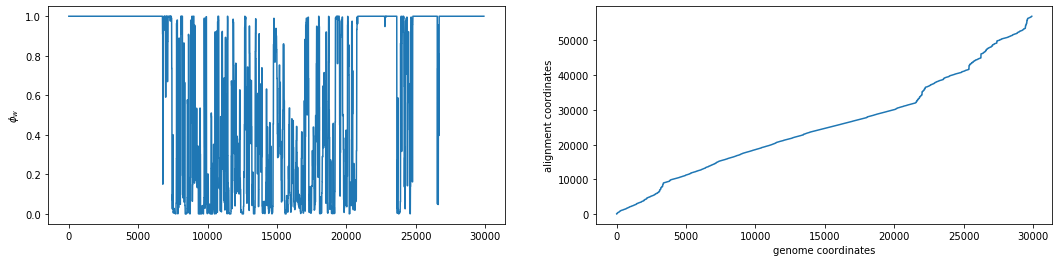

In [9]:
figure( figsize=( 18, 4 ) )

mapping = zeros(len(record))
mapping[:] = 1
gapping = []

for n,row in df1000.iterrows() :
    mapping[ int(row.window - 500) : int(row.window + 499) ] = row.PHI

PHI = zeros( len( str( record.seq).replace('-','') ) )
j = 0
for n,i in enumerate( record.seq ) :
    if i != '-' :
        gapping.append(n)
        PHI[j] = mapping[n]
        j = j+1
    
subplot( 1, 2, 1 )
seaborn.lineplot( range(len(PHI)), PHI )
ylabel( r'$\phi_w$' )
subplot( 1, 2, 2 )
plot( gapping )
xlabel( 'genome coordinates' )
ylabel( 'alignment coordinates' )

Plot $\phi_w$ against the SARS-CoV-2 reference genome annotations, identify
regions where recombination is not likely to have occurred.

In [5]:
import gffpandas.gffpandas as gffpd

annotations = gffpd.read_gff3( 'data/annotations.gff' )
annotations.df.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,NC_045512.2,RefSeq,region,1,29903,.,+,.,ID=NC_045512.2:1..29903;Dbxref=taxon:2697049;c...
1,NC_045512.2,RefSeq,five_prime_UTR,1,265,.,+,.,ID=id-NC_045512.2:1..265;gbkey=5'UTR
2,NC_045512.2,RefSeq,gene,266,21555,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
3,NC_045512.2,RefSeq,CDS,266,13468,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
4,NC_045512.2,RefSeq,CDS,13468,21555,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...


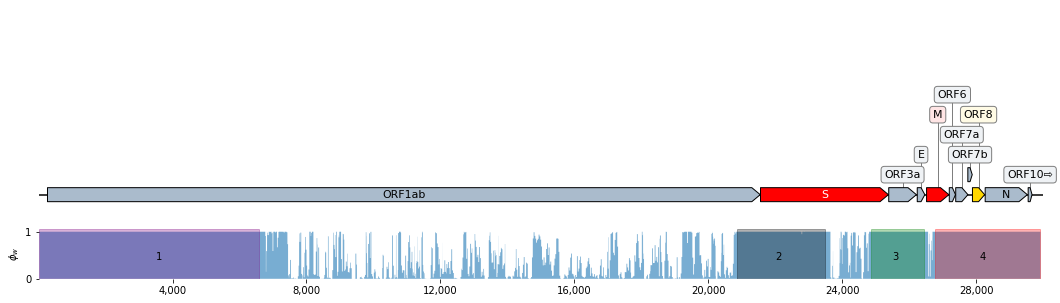

In [10]:
from dna_features_viewer import GraphicFeature, GraphicRecord

fig, (ax1, ax2) = subplots(
    2, 1, figsize=(18, 5), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

# Feature map

replication = [ 'ORF1ab' ]
target      = [ 'ORF8' ]
surface     = [ 'S', 'M' ]

features = []

for i,row in annotations.filter_feature_of_type( ['gene'] ).df.iterrows() :
    attributes = { a.split('=')[0]:a.split('=')[1] for a in row.attributes.split(';') }
    if attributes['Name'] in target        : color = '#ffd700'
    #elif attributes['Name'] in replication : color = '#aabbcc'
    elif attributes['Name'] in surface     : color = '#ff0000'
    else                                   : color = '#aabbcc'
    features.append( GraphicFeature( start=row.start,
                                     end=row.end,
                                     strand=+1,
                                     color=color,
                                     label=attributes['Name'] ) )

grecord = GraphicRecord(sequence_length=30000, features=features)
grecord.plot( ax=ax1, with_ruler=False, strand_in_label_threshold=4 )

# Track plot

xx = np.arange( len(PHI) )
ax2.fill_between( xx + 25, PHI, alpha=0.6 )
ax2.set_ylim( bottom=0 )
ax2.set_ylabel( r'$\phi_w$' )
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([4000,8000,12000,16000,20000,24000,28000])

axvspan( 0,     6570, alpha=.3, color='purple' )
axvspan( 20850, 23500, alpha=.3, color='black' )
axvspan( 24850, 26450, alpha=.3, color='green' )
axvspan( 26760, len(PHI), alpha=.3, color='red' )

ax2.text(  3500, 0.4, '1' )
ax2.text( 22000, 0.4, '2' )
ax2.text( 25500, 0.4, '3' )
ax2.text( 28100, 0.4, '4' )

savefig( 'figures/breakpoints.pdf' )

In [11]:
# non-recombining block coordinates in SARS-CoV-2 reference genome coordinates
block1g = ( 0,      6570        )
block2g = ( 20850, 23500        )
block3g = ( 24850, 26450        )
block4g = ( 26760, len(PHI) - 1 )
blocksg = [ block1g, block2g, block3g, block4g ]

# non-recombining block coordinates in alignment coordinates
blocksa = [ ( gapping[a], gapping[b] ) for a,b in blocksg ]
block1a, block2a, block3a, block4a = blocksa

Create alignment files for each of the four non-recombining regions.

In [12]:
from Bio import SeqIO

for n,(start,stop) in enumerate( blocksa ) :
    with open( 'data/block_' + str(n+1) + '_aln.fasta', 'w' ) as output :
        with open( 'data/refcov89_fullgenome_alignment.fasta' ) as f :
            for record in SeqIO.parse( f, format='fasta' ) :
                output.write( record[ start:stop ].format( 'fasta' ) )

Build maximum likelihood phylogenetic trees for each non-recombining region using RAxML.

In [26]:
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_1_aln.fasta -n trees/block_1 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_2_aln.fasta -n trees/block_2 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_3_aln.fasta -n trees/block_3 -p 1024 -T 8 --silent
!raxmlHPC-PTHREADS-AVX -m GTRGAMMA -s data/block_4_aln.fasta -n trees/block_4 -p 1024 -T 8 --silent


RAxML can't, parse the alignment file as phylip file 
it will now try to parse it as FASTA file

An alignment file with undetermined columns removed has already
been printed to file data/block_1_aln.fasta.reduced


Using BFGS method to optimize GTR rate parameters, to disable this specify "--no-bfgs" 


Alignment has 308 completely undetermined sites that will be automatically removed from the input data


This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 2

This is RAxML Worker Pthread Number: 3

This is RAxML Worker Pthread Number: 1

This is RAxML Worker Pthread Number: 4

This is RAxML Worker Pthread Number: 5

This is RAxML Worker Pthread Number: 6

This is RAxML Worker Pthread Number: 7


This is RAxML version 8.2.12 released by Alexandros Stamatakis on May 2018.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Kassian Kobert    (HITS)
David Dao         (KIT and HITS)
Sarah Lutteropp 


RAxML can't, parse the alignment file as phylip file 
it will now try to parse it as FASTA file


IMPORTANT WARNING: Alignment validation warnings have been suppressed. Found 0 duplicate sequence and 170 undetermined columns

Just in case you might need it, an alignment file with 
undetermined columns removed is printed to file data/block_4_aln.fasta.reduced


Using BFGS method to optimize GTR rate parameters, to disable this specify "--no-bfgs" 


Alignment has 170 completely undetermined sites that will be automatically removed from the input data


This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1

This is RAxML Worker Pthread Number: 2

This is RAxML Worker Pthread Number: 3

This is RAxML Worker Pthread Number: 4

This is RAxML Worker Pthread Number: 5

This is RAxML Worker Pthread Number: 6

This is RAxML Worker Pthread Number: 7


This is RAxML version 8.2.12 released by Alexandros Stamatakis on May 2018.

With greatly appreciated code contributions by:
A

Examine the topological dissimilarity among the trees inferred for each
non-recombining region.

block_1 vs. block_2 :  KendalltauResult(correlation=0.2351665564476867, pvalue=6.952951126223239e-108)
block_1 vs. block_3 :  KendalltauResult(correlation=0.3948561905482213, pvalue=1.9950174765071034e-300)
block_1 vs. block 4 :  KendalltauResult(correlation=0.2213518317439754, pvalue=8.392266000985188e-96)
block_2 vs. block_3 :  KendalltauResult(correlation=0.2011395239453511, pvalue=1.941380990081143e-79)
block_2 vs. block 4 :  KendalltauResult(correlation=0.10118243660826524, pvalue=2.2353063767094666e-21)
block_3 vs. block 4 :  KendalltauResult(correlation=0.3370319493527552, pvalue=1.8392697804385754e-219)


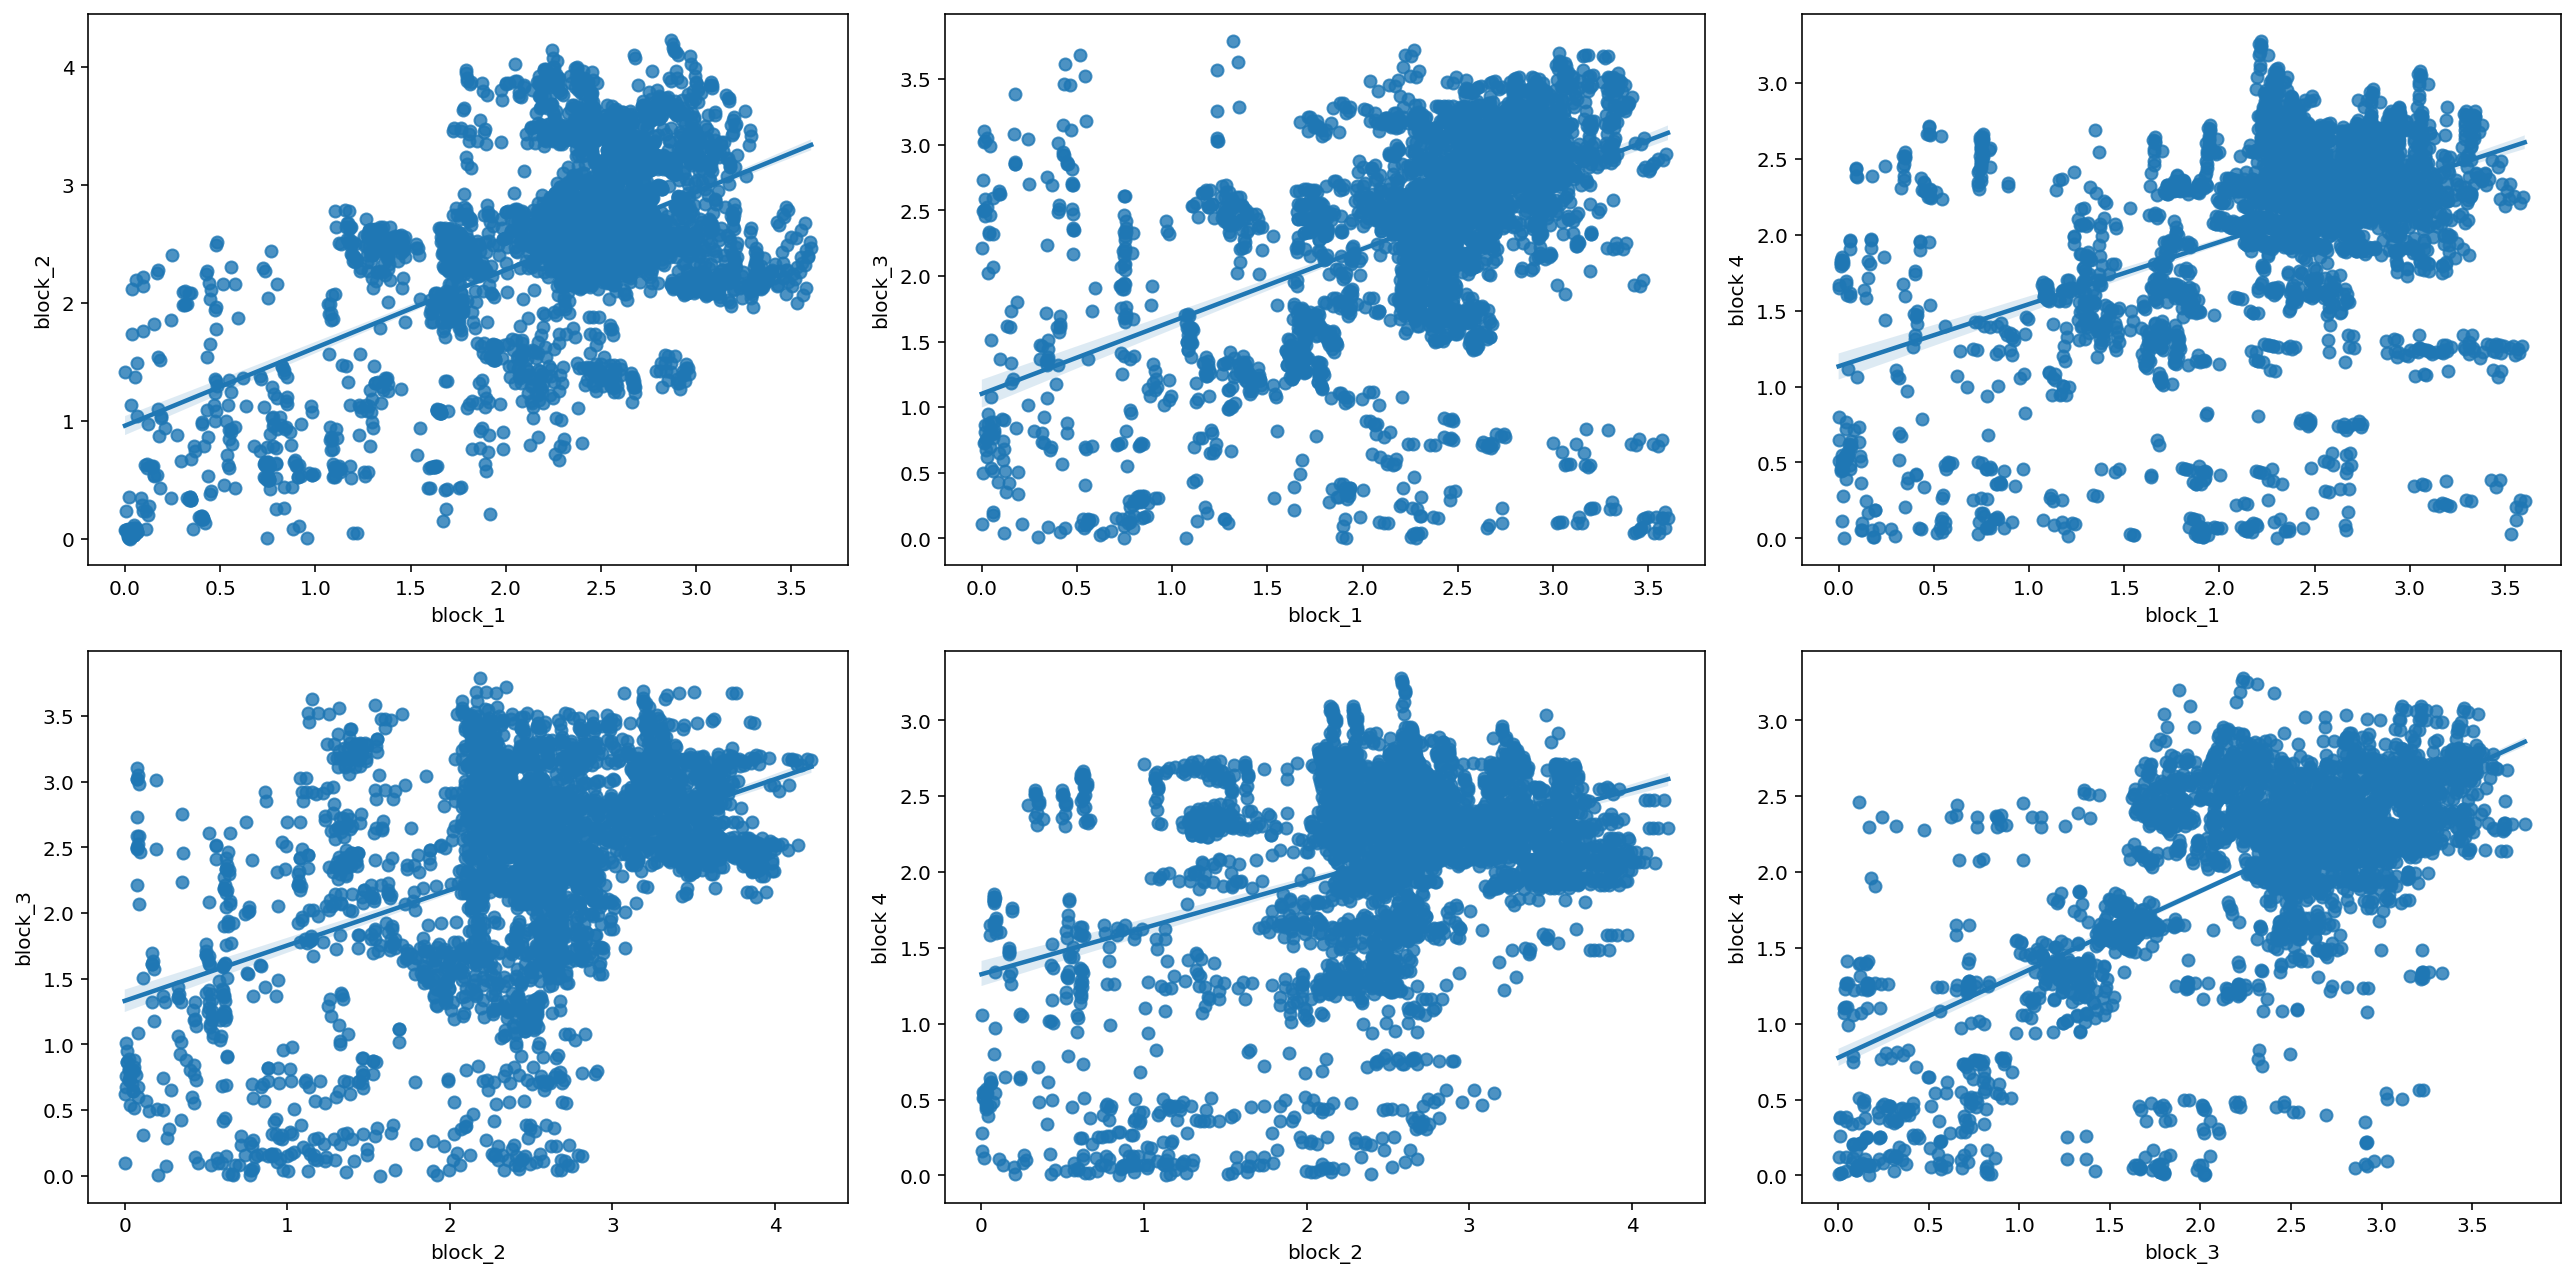

In [18]:
from SuchTree import SuchTree, SuchLinkedTrees
from itertools import combinations
from scipy.stats import pearsonr, kendalltau

figure( figsize=( 18, 9 ) )

block1t = SuchTree( 'trees/RAxML_bestTree.block_1' )
block2t = SuchTree( 'trees/RAxML_bestTree.block_2' )
block3t = SuchTree( 'trees/RAxML_bestTree.block_3' )
block4t = SuchTree( 'trees/RAxML_bestTree.block_4' )

block1d = block1t.distances_by_name( list( combinations( block1t.leafnodes.values(), 2 ) ) )
block2d = block2t.distances_by_name( list( combinations( block2t.leafnodes.values(), 2 ) ) )
block3d = block3t.distances_by_name( list( combinations( block3t.leafnodes.values(), 2 ) ) )
block4d = block4t.distances_by_name( list( combinations( block4t.leafnodes.values(), 2 ) ) )

block_distances = pandas.DataFrame( { 'block_1' : block1d,
                                      'block_2' : block2d,
                                      'block_3' : block3d,
                                      'block 4' : block4d } )

#g = seaborn.PairGrid( block_distances, diag_sharey=False )
#g.map_upper( seaborn.regplot )
#g.map_lower( seaborn.kdeplot, colors="C0" )
#g.map_diag( seaborn.kdeplot, lw=2 )

for n,(a,b) in enumerate( combinations( block_distances.columns, 2 ) ) :
    subplot( 2, 3, n+1 )
    seaborn.regplot( a, b, data=block_distances )
    print( a + ' vs. ' + b + ' : ', kendalltau( block_distances[a], block_distances[b] ) )
    
tight_layout()

([<matplotlib.axis.XTick at 0x7f15b096f8d0>,
 <a list of 23 Text xticklabel objects>)

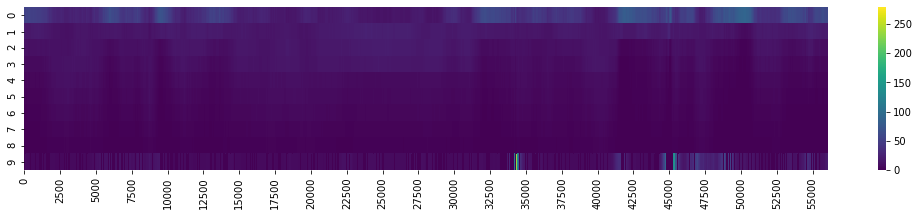

In [242]:
incompatibility_scores = []
centers = []

for i,block in enumerate( open( 'Profile_w1000.log' ).read().split( 'Checking for recombination at ' ) ) :
    if i == 0 : continue # skip the log header
    block = block.split('\n')
    center, X, start, X, end = block[0].split()
    centers.append(center)
    scores = []
    for j in range(10) :
        score = block[3+j][6:10]
        try :
            scores.append( float(score) )
        except :
            scores.append( 0 )
    incompatibility_scores.append( scores )

incompatibility_scores = array( incompatibility_scores ).T

figure( figsize=(18,3) )
seaborn.heatmap( incompatibility_scores, cmap='viridis' )
xticks(       [ i for i in range( 0, len(centers), 100 ) ], 
    labels=[ 25*i for i in range( 0, len(centers), 100 ) ] )